In [12]:
print("Hello world")

Hello world


In [13]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA RTX 2000 Ada Generation Laptop GPU
Using device: cuda


In [14]:
# Basic libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Image processing
import cv2
from PIL import Image

# PyTorch core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Torchvision (models, transforms, datasets)
import torchvision
from torchvision import datasets, transforms, models

# Progress bar
from tqdm import tqdm

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix

### Split the DataSet

In [15]:
# import os
# import shutil
# import random

# # Paths
# source_dir = "data"   # contains with_mask, without_mask
# train_dir = "data/train"
# val_dir = "data/val"

# split_ratio = 0.8  # 80% train, 20% validation
# classes = ["with_mask", "without_mask"]

# # Create directories
# for split in [train_dir, val_dir]:
#     for cls in classes:
#         os.makedirs(os.path.join(split, cls), exist_ok=True)

# # Split data
# for cls in classes:
#     cls_path = os.path.join(source_dir, cls)
#     images = os.listdir(cls_path)
#     random.shuffle(images)

#     split_point = int(len(images) * split_ratio)
#     train_images = images[:split_point]
#     val_images = images[split_point:]

#     for img in train_images:
#         shutil.copy(os.path.join(cls_path, img),
#                     os.path.join(train_dir, cls, img))

#     for img in val_images:
#         shutil.copy(os.path.join(cls_path, img),
#                     os.path.join(val_dir, cls, img))


### Step 1: Data Preprocessing & Augmentation

In [16]:
from torchvision import transforms

IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

### Step 2: Dataset & DataLoader

In [17]:
from torchvision import datasets
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# Dataset paths
train_dir = "data/train"
val_dir = "data/val"

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Class names
class_names = train_dataset.classes
print(class_names)

['with_mask', 'without_mask']


### Step 3: Model (Transfer Learning – ResNet18) 

In [18]:
import torch.nn as nn    # Neural network layers (Linear, Loss, etc.)
from torchvision import models # Loads pretrained models like ResNet18

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Freeze backbone layers
for param in model.parameters():
    param.requires_grad = False

# Replace final fully connected layer (2 classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model.fc)

Linear(in_features=512, out_features=2, bias=True)


c:\Users\faisa\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\faisa\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Step 4: Loss, Optimizer, Scheduler

In [19]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss() #Loss for multi-class classification (2 classes here)

# Optimizer (only train the final layer)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) #Reduces learning rate every 7 epochs by ×0.1

In [20]:
import numpy as np
print(np.__version__)


1.26.4


### Step 5: Training & Validation Loop

In [21]:
num_epochs = 20

train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

c:\Users\faisa\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/20] Train Loss: 0.2394, Train Acc: 0.9233 | Val Loss: 0.0949, Val Acc: 0.9815
Epoch [2/20] Train Loss: 0.1232, Train Acc: 0.9585 | Val Loss: 0.0765, Val Acc: 0.9782
Epoch [3/20] Train Loss: 0.0965, Train Acc: 0.9677 | Val Loss: 0.0651, Val Acc: 0.9828
Epoch [4/20] Train Loss: 0.0884, Train Acc: 0.9693 | Val Loss: 0.0585, Val Acc: 0.9841
Epoch [5/20] Train Loss: 0.0834, Train Acc: 0.9704 | Val Loss: 0.0532, Val Acc: 0.9841
Epoch [6/20] Train Loss: 0.0787, Train Acc: 0.9738 | Val Loss: 0.0515, Val Acc: 0.9848
Epoch [7/20] Train Loss: 0.0713, Train Acc: 0.9745 | Val Loss: 0.0502, Val Acc: 0.9841
Epoch [8/20] Train Loss: 0.0668, Train Acc: 0.9775 | Val Loss: 0.0456, Val Acc: 0.9874
Epoch [9/20] Train Loss: 0.0636, Train Acc: 0.9782 | Val Loss: 0.0508, Val Acc: 0.9828
Epoch [10/20] Train Loss: 0.0720, Train Acc: 0.9738 | Val Loss: 0.0482, Val Acc: 0.9848
Epoch [11/20] Train Loss: 0.0631, Train Acc: 0.9772 | Val Loss: 0.0461, Val Acc: 0.9868
Epoch [12/20] Train Loss: 0.0714, Train A

### Step 6: Plot Train–Validation Accuracy

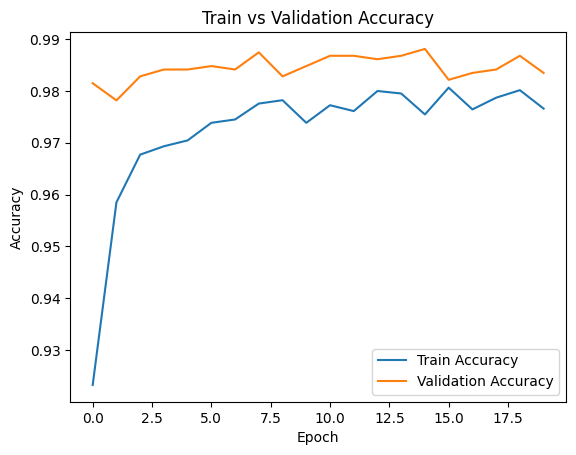

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.show()

### Step 7: Plot Train–Validation Loss

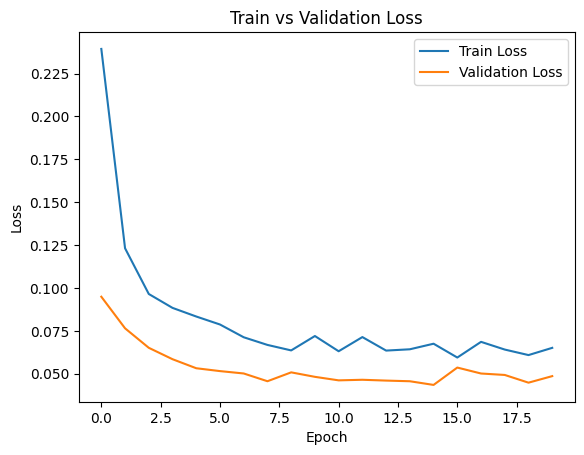

In [23]:
plt.figure()
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

### Step 8: Confusion Matrix

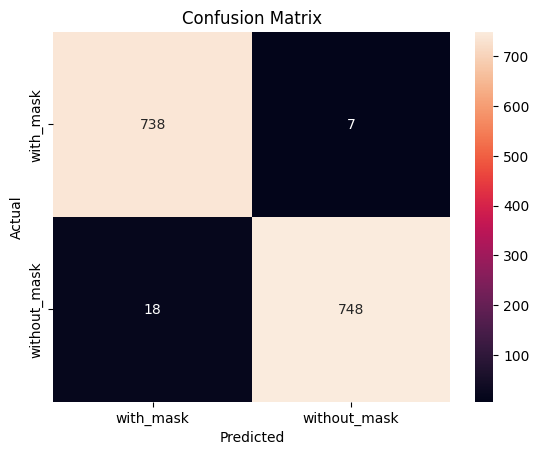

In [24]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Save the model

In [25]:
# Save trained model
torch.save(model.state_dict(), "resnet18_mask_detector.pth")

### Single Image Prediction (Inference)

In [29]:
import torch
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F

# Load model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("resnet18_mask_detector.pth", map_location=device))
model = model.to(device)
model.eval()

# Image preprocessing (same as validation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load image
img_path = "images (1).jfif"   # change path
image = Image.open(img_path).convert("RGB")
image = transform(image).unsqueeze(0).to(device)

# Prediction
with torch.no_grad():
    outputs = model(image)
    probs = F.softmax(outputs, dim=1)
    confidence, pred = torch.max(probs, 1)

label = class_names[pred.item()]
confidence = confidence.item() * 100

print(f"Prediction: {label} ({confidence:.2f}%)")

Prediction: with_mask (100.00%)
